## Submission: Davide Lamagna, Marc Parce, 9th December 2025

# IRRS Lab Session 6: Duplicate detection using simhash

In this session you will:

- implement the simhashing algorithm
- apply it to the `arxiv` abstracts to detect near duplicates among documents in this index

## 1. Simhash-based near-duplicate detection algorithm

We depart from an indexed corpus, namely the one that we have used in previous sessions that contains 58102 abstracts from the
scientific [arXiv.org](https://arxiv.org) repository. The following pseudocode uses $k,m$ as the usual parameters for lsh (locality sensitive hashing)
scheme for gap amplification (repetition of $m$ lsh tables, using $k$ projections each).

  1. For each word $t$ in the vocabulary $V$ we generate $b = k\times m$ random $\pm 1$ signs:
      - generate a unique hash (bitstring) $h_t$ of size $b$
      - let $h'_t$ be the hash above but replacing each 0 with -1.
  
  2. We view each document as a tf-idf weighted sum of its terms. Thus, to hash a document, we sum the weighted contributions of all its terms. Specifically, for each document in our corpus represented by list of non-zero entries $t, w_t$:
      - compute $simhash(d)$ as sum $\sum_t h'_t * w_t$. 
      - convert $simhash(d)$ to bit vector using the sign of entries (positive entries become 1, negative ones become 0)
  
  3. Slice simhashes into $m$ chunks of $k$ bits
     - for each $k$-bit chunk:
        - place the document into the bucket given by the chunk in the appropriate table. Note that we may identify each chunk with an integer index between 0 and 2^k - 1.
  
  4. Similar documents will likely fall on the same side of many hyperplanes, and thus share one or more $k$-bit chunks. Thus, the potential duplicates are pairs of documents that fall into the same bucket in **at least one** hash table. Now we need to
     - compute cosine similarity among these potential duplicates, and
     - show pairs in decreasing cosine similarity order.


---

**Exercise 1:**  

As a little exercise, suppose that a document $d$ contains _two_ non-zero entries, which correspond to terms `bit` with tf-idf weight $0.4$ and `coin` with tf-idf weight $1.2$.
The md5 hash code for `bit` is 1111 and the md5 code for `coin` is 1001 (so $b=4$). Compute the binary simhash for this document with $k=4, m = 1$. (_Hint: result should be 1001_)

---



We consider a document containing two terms:

* **“bit”** with tf-idf weight **0.4**, hashed to **1111**
* **“coin”** with tf-idf weight **1.2**, hashed to **1001**

We want to compute the **4-bit Simhash** for this document with **k = 4, m = 1**.


First, we can convert the hases to vectors, where the hash of bit (1111) becomes [1,1,1,1] and the hash of coin (1001) becomes [1,-1,-1,1]

| Term | Hash | ±1 Vector        |
| ---- | ---- | ---------------- |
| bit  | 1111 | [+1, +1, +1, +1] |
| coin | 1001 | [+1, –1, –1, +1] |

IF we let:

* ( w_bit = 0.4 )
* ( w_coin = 1.2 )

Then the accumulator s[j] can be calculated as follows:

| Position | bit contribution | coin contribution | Total (S[j]) |
| -------- | ---------------- | ----------------- | ------------ |
| 1        | +0.4             | +1.2              | **+1.6**     |
| 2        | +0.4             | –1.2              | **–0.8**     |
| 3        | +0.4             | –1.2              | **–0.8**     |
| 4        | +0.4             | +1.2              | **+1.6**     |


We can now apply the sign to get the final simhash

* Positive → **1**
* Negative → **0**

Thus:

| S[j] | Sign | Bit |
| ---- | ---- | --- |
| +1.6 | +    | 1   |
| –0.8 | –    | 0   |
| –0.8 | –    | 0   |
| +1.6 | +    | 1   |

which gives us `1001`


## 2. Hashing codes for terms in vocabulary

To make your life easier, we provide code for generating hash codes for the terms in the vocabulary.
The given function takes as input the size of the hash, as well as the term itself.

We use a fast deterministic hash (MD5) to get repeatable pseudo-random bits. Even though it is actually deterministic, we assume that in practice its output behaviour is sufficiently similar to that of a truly random hash function.

In [1]:
import hashlib
from functools import cache
import numpy as np
from numpy.typing import NDArray


@cache
def termhash(x: str, b: int) -> NDArray[np.uint8]:
    """
    Returns bit array of size b based on md5 algorithm.

    Args:
        x (str): Input string to be hashed
        b (int): Number of bits to return

    Returns:
        NDArray[np.uint8]: Bit array of size b
    """
    assert b <= 128, "this encoding scheme supports hashes of length at most 128; try smaller b"
    h = hashlib.md5(x.encode("utf8")).digest()
    bit_array = np.unpackbits(np.frombuffer(h, dtype=np.uint8))
    # We could use boolean array, but the smallest size for numpy array elements is 8 bits (1 byte),
    # so we wouldn't gain any memory efficiency, and returning uint8 is more convenient for further computations.
    return bit_array[:b]


for w in ["bit", "coin", "hola que tal"]:
    print(f"hash.md5({w}) = {termhash(w, 4)}")

hash.md5(bit) = [1 1 1 1]
hash.md5(coin) = [1 0 0 1]
hash.md5(hola que tal) = [0 1 1 0]


## 3. Loading tf-idf for the whole corpus

We provide the document-term matrix with normalized tf-idf weights with a sparse representation.
This is so that further code does not need to check for tf-idf weights against elasticsearch which is very slow.

Please download the corpus data from https://www.cs.upc.edu/~caim/05corpus.pkl and run the following cells to access the data.

In [2]:
import pickle
from typing import Dict

import numpy as np

fname = "../data/05corpus.pkl"

with open(fname, "rb") as f:
    corpus: Dict[str, Dict[str, np.float32]] = pickle.load(f)

### have a look at the data

Loaded corpus with 58102 documents.
A few document ids are: ['17071', '20273', '29059', '32005', '34782', '35195', '36327', '38886', '42814', '53659']
Each document is a dictionary with term -> tf-idf weights, e.g. the first:


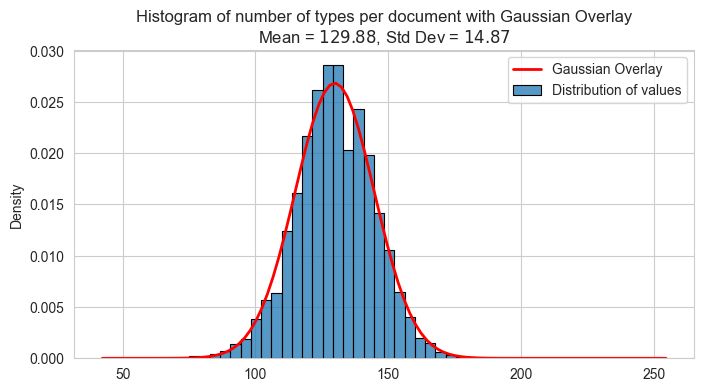

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import random

# show contents

print(f"Loaded corpus with {len(corpus)} documents.")
all_document_ids = list(corpus.keys())
print(f"A few document ids are: {sorted(random.sample(all_document_ids, 10))}")
print(f"Each document is a dictionary with term -> tf-idf weights, e.g. the first:")
# print("Only printing the first 5 for better visibility")
# print(corpus[all_document_ids[0][:5]])

# obtain histogram with nr of terms in each document
values = [len(corpus[id]) for id in all_document_ids]
mu = np.mean(values)
sigma = np.std(values)
plt.figure(figsize=(8, 4))
sns.set_style("whitegrid")
sns.histplot(values, bins=50, edgecolor="black", stat="density", label="Distribution of values")
plt.title(
    f"Histogram of number of types per document with Gaussian Overlay\nMean = ${mu:.2f}$, Std Dev = ${sigma:.2f}$",
    fontsize=12,
)
xmin, xmax = plt.xlim()
x_axis = np.linspace(xmin, xmax, 100)

# Calculate the probability density function (PDF) for the x-values.
plt.plot(x_axis, norm.pdf(x_axis, mu, sigma), "red", linewidth=2, label="Gaussian Overlay")
plt.legend()
# Display the labels

## 4. Simhashing scheme and near-duplicate collection and verification

---

**Exercise 2:**  

Write the `simhash` function provided below. Make sure you understand that each bit of the simhash encodes which "side" the tf-idf document representation falls on a (pseudo-)random projection. 


---


In [4]:
import numpy as np


@cache  # By caching, we avoid recomputing simhashes for the same document multiple times.
def simhash(id: str, b: int) -> NDArray[np.uint8]:
    """
    Compute the b-bit simhash for the document with given id.
    For each term, convert its hash bits into +/- contributions
    weighted by tf-idf, then take the sign of each summed dimension.
    (same as exercise 1)

    Args:
        id (str): Document ID
        b (int): Desired length of the simhash

    Returns:
        NDArray[np.uint8]: The b-bit simhash as a string of '0's and '1's.
    """
    weights = corpus[id]
    signature = np.zeros(b, dtype=np.float32)
    for term, w in weights.items():
        bit_array = termhash(term, b)
        # We know that bit_array is a numpy array of 0s and 1s of type np.uint8.
        # Instead of doing Python loops and conditionals, we can use numpy vectorized operations.
        weight_array = bit_array.astype(np.float32) * 2 - 1  # Convert 0s to -1 and 1s to +1
        signature += w * weight_array

    # End by converting the signature to '0's and '1's based on the sign of each dimension
    simhash_bits = (signature >= 0).astype(np.uint8)
    return simhash_bits

Let us test it by SimHashing all the documents in the corpus.

By doing this, we're also filling the cache of the `simhash` function, so that future calls to it with the same document id will be instantaneous.

In [5]:
## constants
from tqdm import tqdm


K = 18
M = 3
B = M * K

for id in tqdm(corpus.keys()):
    simhash_bits = simhash(id, B)

100%|██████████| 58102/58102 [00:26<00:00, 2195.60it/s]


---

**Exercise 3:**  

Based on simhashes, write code that places the documents in their corresponding lsh hash tables' buckets across $m$ repetitions. Once, the lsh hash tables have been
populated, find all potential near-duplicate candidate pairs. Check among all candidates their real cosine similarity and based on this determine true positives
(pairs of documents that are indeed similar and have collided in some table), and false positives (pairs of documents that are not similar but have collided in some table).
Compute speed of the method vs. false positives / true positives for different values of $m$ and $k$. Make sure that $k$ is not tiny (say greater than 10) if you want
the method to be fast.

---


In [6]:
from collections import defaultdict
from itertools import combinations
import math, time

import math
from typing import List, Set, Tuple


@cache
def corpus_norm(id: str) -> float:
    weights = corpus[id]
    return math.sqrt(sum(w**2 for w in weights.values()))


@cache
def cosine_similarity(id1: str, id2: str) -> float:
    """Compute cosine similarity between two docs using shared tf-idf terms."""
    vec1, vec2 = corpus[id1], corpus[id2]
    common_terms = vec1.keys() & vec2.keys()
    if not common_terms:
        return 0.0
    dot = sum(vec1[t] * vec2[t] for t in common_terms)
    denom = corpus_norm(id1) * corpus_norm(id2)

    if denom:
        return dot / denom
    else:
        return 0.0


def split_signature(sig: NDArray[np.uint8], m: int):
    """Slice a simhash bit array into m chunks of length k"""
    return np.array_split(sig, m)


def build_lsh_tables(k: int, m: int) -> List[Dict[int, List[str]]]:
    """Populate m hash tables mapping each k-bit band to the doc ids in that bucket."""
    tables: List[Dict[int, List[str]]] = [defaultdict(list) for _ in range(m)]

    for doc_id in corpus.keys():
        for table, bucket_hash in enumerate(split_signature(simhash(doc_id, k * m), m)):
            bucket_index = int.from_bytes(np.packbits(bucket_hash).tobytes(), byteorder="big")
            tables[table][bucket_index].append(doc_id)

    return tables


def collect_candidates(tables: List[Dict[int, List[str]]]) -> Set[Tuple[str, str]]:
    """Return all unique doc pairs that co-occur in at least one LSH bucket."""
    candidates = set()
    for table in tables:
        for bucket_docs in table.values():
            for a, b in combinations(bucket_docs, 2):
                if a > b:
                    a, b = b, a
                candidates.add((a, b))

    return candidates


def evaluate_lsh(k: int, m: int, threshold: float):
    """Build LSH tables, gather candidates, and count TP/FP against a threshold."""
    start_time = time.time()
    tables = build_lsh_tables(k, m)
    build_time = time.time()
    print(f"Built LSH tables in {build_time - start_time:.2f}s")
    candidates = collect_candidates(tables)
    candidate_time = time.time()
    print(f"Collected {len(candidates)} candidates in {candidate_time - build_time:.2f}s")

    tp = fp = 0
    for a, b in tqdm(candidates, desc="Evaluating candidates", leave=False, unit="pair"):
        if cosine_similarity(a, b) >= threshold:
            tp += 1
        else:
            fp += 1
    eval_time = time.time()

    print(f"Evaluated candidates in {eval_time - candidate_time:.2f}s")
    print(f"k={k}, m={m}, threshold={threshold}")
    print(f"candidates={len(candidates)}, TP={tp}, FP={fp}")
    return {
        "k": k,
        "m": m,
        "threshold": threshold,
        "candidates": len(candidates),
        "true_positives": tp,
        "false_positives": fp,
        "build_time_sec": build_time - start_time,
        "candidate_time_sec": candidate_time - build_time,
        "eval_time_sec": eval_time - candidate_time,
    }


results = evaluate_lsh(k=K, m=M, threshold=0.9)

print(results)

Built LSH tables in 0.53s
Collected 40276 candidates in 0.12s


Evaluated candidates in 1.15s
k=18, m=3, threshold=0.9
candidates=40276, TP=16031, FP=24245
{'k': 18, 'm': 3, 'threshold': 0.9, 'candidates': 40276, 'true_positives': 16031, 'false_positives': 24245, 'build_time_sec': 0.5335371494293213, 'candidate_time_sec': 0.12489557266235352, 'eval_time_sec': 1.1510365009307861}


In [11]:
import csv
import os

import pandas as pd

# Only k, m pairs where k * m == B (here B = 54)
# parameter_grid = [  # k, m, threshold
#     (9, 6, 0.9),
#     (18, 3, 0.9),  # default
#     (27, 2, 0.9),
#     (21, 6, 0.9),
# ]
parameter_grid: Set[Tuple[int, int, float]] = set()  # k, m, threshold
for threshold in [0.8, 0.85, 0.9]:
    for k in range(15, 27, 2):
        for m in range(2, 128 // k + 1):
            if k * m <= 128:
                parameter_grid.add((k, m, threshold))

print(f"Running evaluations for {len(parameter_grid)} parameter combinations.")
# Load previous results if any
if os.path.exists("../results/results.csv"):
    prev_results = pd.read_csv("../results/results.csv")
    completed_params = set(
        tuple(row) for row in prev_results[["k", "m", "threshold"]].itertuples(index=False, name=None)
    )
parameter_grid = parameter_grid - completed_params
print(f"{len(parameter_grid)} parameter combinations remaining after excluding completed runs.")


os.makedirs("../results", exist_ok=True)
fnames = [
    "m",
    "k",
    "threshold",
    "candidates",
    "true_positives",
    "false_positives",
    "build_time_sec",
    "candidate_time_sec",
    "eval_time_sec",
]
with open("../results/results.csv", "a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fnames)
    print("Running LSH comparisons...\n")
    for k_val, m_val, threshold in parameter_grid:
        print(f"\n=== Evaluating k={k_val}, m={m_val} ===")
        result = evaluate_lsh(k=k_val, m=m_val, threshold=threshold)
        writer.writerow(result)
        f.flush()
print("\nDone. Results saved to ../results/results.csv")

Running evaluations for 93 parameter combinations.
87 parameter combinations remaining after excluding completed runs.
Running LSH comparisons...


=== Evaluating k=15, m=7 ===
Built LSH tables in 27.13s
Collected 438576 candidates in 0.25s


Evaluated candidates in 7.57s
k=15, m=7, threshold=0.85
candidates=438576, TP=18569, FP=420007

=== Evaluating k=19, m=3 ===
Built LSH tables in 43.97s
Collected 28097 candidates in 0.07s


Evaluated candidates in 0.11s
k=19, m=3, threshold=0.9
candidates=28097, TP=15913, FP=12184

=== Evaluating k=25, m=3 ===


Built LSH tables in 31.35s
Collected 15083 candidates in 0.07s


Evaluated candidates in 0.02s
k=25, m=3, threshold=0.85
candidates=15083, TP=14878, FP=205

=== Evaluating k=19, m=4 ===


Built LSH tables in 41.84s
Collected 32331 candidates in 0.10s


Evaluated candidates in 0.03s
k=19, m=4, threshold=0.85
candidates=32331, TP=16609, FP=15722

=== Evaluating k=17, m=5 ===


Built LSH tables in 29.03s
Collected 93529 candidates in 0.11s


Evaluated candidates in 0.64s
k=17, m=5, threshold=0.8
candidates=93529, TP=17499, FP=76030

=== Evaluating k=23, m=5 ===
Built LSH tables in 28.62s
Collected 17679 candidates in 0.11s


Evaluated candidates in 0.02s
k=23, m=5, threshold=0.8
candidates=17679, TP=16328, FP=1351

=== Evaluating k=17, m=4 ===


Built LSH tables in 37.16s
Collected 78860 candidates in 0.08s


Evaluated candidates in 0.07s
k=17, m=4, threshold=0.85
candidates=78860, TP=16997, FP=61863

=== Evaluating k=15, m=8 ===


Built LSH tables in 30.32s
Collected 501058 candidates in 0.26s


Evaluated candidates in 1.06s
k=15, m=8, threshold=0.8
candidates=501058, TP=18953, FP=482105

=== Evaluating k=25, m=4 ===
Built LSH tables in 36.52s
Collected 15746 candidates in 0.11s


Evaluated candidates in 0.02s
k=25, m=4, threshold=0.8
candidates=15746, TP=15496, FP=250

=== Evaluating k=15, m=2 ===


Built LSH tables in 32.21s
Collected 133772 candidates in 0.06s


Evaluated candidates in 0.11s
k=15, m=2, threshold=0.85
candidates=133772, TP=15949, FP=117823



=== Evaluating k=19, m=5 ===
Built LSH tables in 29.54s
Collected 36721 candidates in 0.10s


Evaluated candidates in 0.08s
k=19, m=5, threshold=0.8
candidates=36721, TP=17213, FP=19508



=== Evaluating k=19, m=6 ===
Built LSH tables in 40.58s
Collected 41463 candidates in 0.26s


Evaluated candidates in 0.13s
k=19, m=6, threshold=0.85
candidates=41463, TP=17465, FP=23998

=== Evaluating k=17, m=7 ===
Built LSH tables in 32.02s
Collected 126634 candidates in 0.16s


Evaluated candidates in 0.38s
k=17, m=7, threshold=0.8
candidates=126634, TP=18087, FP=108547

=== Evaluating k=21, m=5 ===
Built LSH tables in 1.09s
Collected 21665 candidates in 0.12s


Evaluated candidates in 0.06s
k=21, m=5, threshold=0.85
candidates=21665, TP=16617, FP=5048



=== Evaluating k=23, m=4 ===
Built LSH tables in 39.94s
Collected 16913 candidates in 0.10s


Evaluated candidates in 0.02s
k=23, m=4, threshold=0.9
candidates=16913, TP=15739, FP=1174

=== Evaluating k=21, m=2 ===


Built LSH tables in 30.38s
Collected 16799 candidates in 0.04s


Evaluated candidates in 0.01s
k=21, m=2, threshold=0.8
candidates=16799, TP=14819, FP=1980

=== Evaluating k=15, m=4 ===


Built LSH tables in 26.59s
Collected 259840 candidates in 0.10s


Evaluated candidates in 0.16s
k=15, m=4, threshold=0.85
candidates=259840, TP=17469, FP=242371

=== Evaluating k=17, m=5 ===
Built LSH tables in 0.98s
Collected 93529 candidates in 0.11s


Evaluated candidates in 0.08s
k=17, m=5, threshold=0.85
candidates=93529, TP=17403, FP=76126

=== Evaluating k=23, m=5 ===
Built LSH tables in 0.85s
Collected 17679 candidates in 0.09s


Evaluated candidates in 0.02s
k=23, m=5, threshold=0.85
candidates=17679, TP=16297, FP=1382

=== Evaluating k=15, m=7 ===


Built LSH tables in 0.83s
Collected 438576 candidates in 0.32s


Evaluated candidates in 0.28s
k=15, m=7, threshold=0.9
candidates=438576, TP=18035, FP=420541

=== Evaluating k=21, m=6 ===
Built LSH tables in 45.35s
Collected 23041 candidates in 0.29s


Evaluated candidates in 0.02s
k=21, m=6, threshold=0.8
candidates=23041, TP=16991, FP=6050

=== Evaluating k=25, m=3 ===


Built LSH tables in 0.91s
Collected 15083 candidates in 0.07s


Evaluated candidates in 0.01s
k=25, m=3, threshold=0.9
candidates=15083, TP=14813, FP=270

=== Evaluating k=15, m=8 ===


Built LSH tables in 1.35s
Collected 501058 candidates in 0.30s


Evaluated candidates in 0.37s
k=15, m=8, threshold=0.85
candidates=501058, TP=18742, FP=482316

=== Evaluating k=19, m=4 ===
Built LSH tables in 0.64s
Collected 32331 candidates in 0.22s


Evaluated candidates in 0.02s
k=19, m=4, threshold=0.9
candidates=32331, TP=16431, FP=15900

=== Evaluating k=17, m=2 ===


Built LSH tables in 32.01s
Collected 45594 candidates in 0.06s


Evaluated candidates in 0.05s
k=17, m=2, threshold=0.8
candidates=45594, TP=15503, FP=30091

=== Evaluating k=23, m=2 ===


Built LSH tables in 46.55s
Collected 15051 candidates in 0.04s


Evaluated candidates in 0.02s
k=23, m=2, threshold=0.8
candidates=15051, TP=14503, FP=548

=== Evaluating k=17, m=4 ===


Built LSH tables in 0.94s
Collected 78860 candidates in 0.26s


Evaluated candidates in 0.07s
k=17, m=4, threshold=0.9
candidates=78860, TP=16745, FP=62115

=== Evaluating k=21, m=4 ===


Built LSH tables in 42.50s
Collected 20260 candidates in 0.09s


Evaluated candidates in 0.02s
k=21, m=4, threshold=0.8
candidates=20260, TP=16226, FP=4034

=== Evaluating k=25, m=2 ===


Built LSH tables in 42.38s
Collected 14274 candidates in 0.22s


Evaluated candidates in 0.01s
k=25, m=2, threshold=0.85
candidates=14274, TP=14142, FP=132

=== Evaluating k=25, m=4 ===


Built LSH tables in 1.25s
Collected 15746 candidates in 0.08s


Evaluated candidates in 0.02s
k=25, m=4, threshold=0.85
candidates=15746, TP=15477, FP=269

=== Evaluating k=19, m=5 ===


Built LSH tables in 0.94s
Collected 36721 candidates in 0.11s


Evaluated candidates in 0.04s
k=19, m=5, threshold=0.85
candidates=36721, TP=17167, FP=19554

=== Evaluating k=17, m=6 ===


Built LSH tables in 31.71s
Collected 110460 candidates in 0.30s


Evaluated candidates in 0.10s
k=17, m=6, threshold=0.8
candidates=110460, TP=17793, FP=92667

=== Evaluating k=17, m=7 ===
Built LSH tables in 1.26s
Collected 126634 candidates in 0.19s


Evaluated candidates in 0.11s
k=17, m=7, threshold=0.85
candidates=126634, TP=17951, FP=108683

=== Evaluating k=15, m=2 ===
Built LSH tables in 0.37s
Collected 133772 candidates in 0.15s


Evaluated candidates in 0.10s
k=15, m=2, threshold=0.9
candidates=133772, TP=15763, FP=118009

=== Evaluating k=19, m=2 ===


Built LSH tables in 33.94s
Collected 22930 candidates in 0.05s


Evaluated candidates in 0.02s
k=19, m=2, threshold=0.8
candidates=22930, TP=15192, FP=7738

=== Evaluating k=19, m=6 ===


Built LSH tables in 1.61s
Collected 41463 candidates in 0.14s


Evaluated candidates in 0.04s
k=19, m=6, threshold=0.9
candidates=41463, TP=17155, FP=24308



=== Evaluating k=21, m=2 ===
Built LSH tables in 0.43s
Collected 16799 candidates in 0.04s


Evaluated candidates in 0.02s
k=21, m=2, threshold=0.85
candidates=16799, TP=14798, FP=2001

=== Evaluating k=25, m=5 ===


Built LSH tables in 34.61s
Collected 16254 candidates in 0.11s


Evaluated candidates in 0.02s
k=25, m=5, threshold=0.8
candidates=16254, TP=15919, FP=335

=== Evaluating k=21, m=5 ===


Built LSH tables in 1.48s
Collected 21665 candidates in 0.13s


Evaluated candidates in 0.03s
k=21, m=5, threshold=0.9
candidates=21665, TP=16475, FP=5190



=== Evaluating k=15, m=5 ===
Built LSH tables in 0.92s
Collected 316452 candidates in 0.20s


Evaluated candidates in 0.29s
k=15, m=5, threshold=0.85
candidates=316452, TP=17859, FP=298593

=== Evaluating k=15, m=3 ===
Built LSH tables in 37.12s
Collected 198207 candidates in 0.20s


Evaluated candidates in 0.25s
k=15, m=3, threshold=0.85
candidates=198207, TP=16838, FP=181369

=== Evaluating k=21, m=6 ===
Built LSH tables in 2.37s
Collected 23041 candidates in 0.17s


Evaluated candidates in 0.04s
k=21, m=6, threshold=0.85
candidates=23041, TP=16942, FP=6099

=== Evaluating k=15, m=4 ===
Built LSH tables in 1.11s
Collected 259840 candidates in 0.37s


Evaluated candidates in 0.24s
k=15, m=4, threshold=0.9
candidates=259840, TP=17166, FP=242674

=== Evaluating k=17, m=2 ===
Built LSH tables in 0.59s
Collected 45594 candidates in 0.06s


Evaluated candidates in 0.05s
k=17, m=2, threshold=0.85
candidates=45594, TP=15473, FP=30121

=== Evaluating k=23, m=2 ===


Built LSH tables in 0.73s
Collected 15051 candidates in 0.19s


Evaluated candidates in 0.02s
k=23, m=2, threshold=0.85
candidates=15051, TP=14487, FP=564

=== Evaluating k=17, m=5 ===
Built LSH tables in 1.26s
Collected 93529 candidates in 0.17s


Evaluated candidates in 0.12s
k=17, m=5, threshold=0.9
candidates=93529, TP=17126, FP=76403

=== Evaluating k=21, m=3 ===
Built LSH tables in 34.98s
Collected 18811 candidates in 0.06s


Evaluated candidates in 0.02s
k=21, m=3, threshold=0.8
candidates=18811, TP=15687, FP=3124

=== Evaluating k=21, m=4 ===


Built LSH tables in 1.19s
Collected 20260 candidates in 0.09s


Evaluated candidates in 0.02s
k=21, m=4, threshold=0.85
candidates=20260, TP=16191, FP=4069

=== Evaluating k=23, m=5 ===


Built LSH tables in 1.13s
Collected 17679 candidates in 0.12s


Evaluated candidates in 0.02s
k=23, m=5, threshold=0.9
candidates=17679, TP=16156, FP=1523

=== Evaluating k=15, m=8 ===


Built LSH tables in 1.28s
Collected 501058 candidates in 0.29s


Evaluated candidates in 0.40s
k=15, m=8, threshold=0.9
candidates=501058, TP=18167, FP=482891

=== Evaluating k=17, m=6 ===
Built LSH tables in 0.99s
Collected 110460 candidates in 0.15s


Evaluated candidates in 0.09s
k=17, m=6, threshold=0.85
candidates=110460, TP=17677, FP=92783

=== Evaluating k=25, m=4 ===
Built LSH tables in 0.76s
Collected 15746 candidates in 0.09s


Evaluated candidates in 0.01s
k=25, m=4, threshold=0.9
candidates=15746, TP=15402, FP=344

=== Evaluating k=25, m=2 ===


Built LSH tables in 0.45s
Collected 14274 candidates in 0.04s


Evaluated candidates in 0.01s
k=25, m=2, threshold=0.9
candidates=14274, TP=14092, FP=182

=== Evaluating k=19, m=2 ===


Built LSH tables in 0.50s
Collected 22930 candidates in 0.04s


Evaluated candidates in 0.02s
k=19, m=2, threshold=0.85
candidates=22930, TP=15168, FP=7762

=== Evaluating k=19, m=5 ===


Built LSH tables in 1.17s
Collected 36721 candidates in 0.13s


Evaluated candidates in 0.04s
k=19, m=5, threshold=0.9
candidates=36721, TP=16895, FP=19826

=== Evaluating k=17, m=3 ===


Built LSH tables in 60.77s
Collected 63786 candidates in 0.42s


Evaluated candidates in 0.11s
k=17, m=3, threshold=0.8
candidates=63786, TP=16489, FP=47297

=== Evaluating k=23, m=3 ===
Built LSH tables in 46.11s
Collected 16120 candidates in 0.07s


Evaluated candidates in 0.01s
k=23, m=3, threshold=0.8
candidates=16120, TP=15328, FP=792

=== Evaluating k=25, m=5 ===


Built LSH tables in 2.03s
Collected 16254 candidates in 0.14s


Evaluated candidates in 0.02s
k=25, m=5, threshold=0.85
candidates=16254, TP=15894, FP=360



=== Evaluating k=17, m=7 ===
Built LSH tables in 1.50s
Collected 126634 candidates in 0.47s


Evaluated candidates in 0.13s
k=17, m=7, threshold=0.9
candidates=126634, TP=17589, FP=109045



=== Evaluating k=21, m=2 ===
Built LSH tables in 0.47s
Collected 16799 candidates in 0.05s


Evaluated candidates in 0.01s
k=21, m=2, threshold=0.9
candidates=16799, TP=14715, FP=2084

=== Evaluating k=25, m=2 ===


Built LSH tables in 0.66s
Collected 14274 candidates in 0.04s


Evaluated candidates in 0.02s
k=25, m=2, threshold=0.8
candidates=14274, TP=14156, FP=118

=== Evaluating k=15, m=5 ===


Built LSH tables in 1.20s
Collected 316452 candidates in 0.19s


Evaluated candidates in 0.27s
k=15, m=5, threshold=0.9
candidates=316452, TP=17506, FP=298946

=== Evaluating k=15, m=3 ===
Built LSH tables in 0.51s
Collected 198207 candidates in 0.10s


Evaluated candidates in 0.16s
k=15, m=3, threshold=0.9
candidates=198207, TP=16593, FP=181614

=== Evaluating k=19, m=3 ===
Built LSH tables in 0.82s
Collected 28097 candidates in 0.08s


Evaluated candidates in 0.03s
k=19, m=3, threshold=0.8
candidates=28097, TP=16103, FP=11994

=== Evaluating k=21, m=3 ===


Built LSH tables in 0.79s
Collected 18811 candidates in 0.32s


Evaluated candidates in 0.02s
k=21, m=3, threshold=0.85
candidates=18811, TP=15661, FP=3150

=== Evaluating k=17, m=2 ===


Built LSH tables in 0.50s
Collected 45594 candidates in 0.05s


Evaluated candidates in 0.04s
k=17, m=2, threshold=0.9
candidates=45594, TP=15362, FP=30232

=== Evaluating k=23, m=2 ===


Built LSH tables in 0.88s
Collected 15051 candidates in 0.19s


Evaluated candidates in 0.01s
k=23, m=2, threshold=0.9
candidates=15051, TP=14421, FP=630

=== Evaluating k=21, m=4 ===
Built LSH tables in 0.94s
Collected 20260 candidates in 0.12s


Evaluated candidates in 0.04s
k=21, m=4, threshold=0.9
candidates=20260, TP=16063, FP=4197



=== Evaluating k=17, m=6 ===
Built LSH tables in 1.38s
Collected 110460 candidates in 0.21s


Evaluated candidates in 0.12s
k=17, m=6, threshold=0.9
candidates=110460, TP=17361, FP=93099

=== Evaluating k=17, m=3 ===
Built LSH tables in 0.86s
Collected 63786 candidates in 0.08s


Evaluated candidates in 0.07s
k=17, m=3, threshold=0.85
candidates=63786, TP=16431, FP=47355

=== Evaluating k=23, m=3 ===


Built LSH tables in 1.11s
Collected 16120 candidates in 0.09s


Evaluated candidates in 0.02s
k=23, m=3, threshold=0.85
candidates=16120, TP=15307, FP=813

=== Evaluating k=15, m=6 ===


Built LSH tables in 48.67s
Collected 374830 candidates in 0.19s


Evaluated candidates in 0.42s
k=15, m=6, threshold=0.85
candidates=374830, TP=18314, FP=356516

=== Evaluating k=19, m=2 ===
Built LSH tables in 1.11s
Collected 22930 candidates in 0.15s


Evaluated candidates in 0.01s
k=19, m=2, threshold=0.9
candidates=22930, TP=15071, FP=7859

=== Evaluating k=25, m=5 ===


Built LSH tables in 1.28s
Collected 16254 candidates in 0.12s


Evaluated candidates in 0.01s
k=25, m=5, threshold=0.9
candidates=16254, TP=15801, FP=453



=== Evaluating k=19, m=3 ===
Built LSH tables in 0.85s
Collected 28097 candidates in 0.23s


Evaluated candidates in 0.03s
k=19, m=3, threshold=0.85
candidates=28097, TP=16066, FP=12031

=== Evaluating k=23, m=4 ===


Built LSH tables in 1.21s
Collected 16913 candidates in 0.11s


Evaluated candidates in 0.03s
k=23, m=4, threshold=0.8
candidates=16913, TP=15880, FP=1033

=== Evaluating k=15, m=7 ===


Built LSH tables in 1.50s
Collected 438576 candidates in 0.31s


Evaluated candidates in 0.44s
k=15, m=7, threshold=0.8
candidates=438576, TP=18760, FP=419816

=== Evaluating k=21, m=3 ===
Built LSH tables in 0.93s
Collected 18811 candidates in 0.07s


Evaluated candidates in 0.02s
k=21, m=3, threshold=0.9
candidates=18811, TP=15553, FP=3258

=== Evaluating k=25, m=3 ===


Built LSH tables in 0.92s
Collected 15083 candidates in 0.08s


Evaluated candidates in 0.02s
k=25, m=3, threshold=0.8
candidates=15083, TP=14896, FP=187

=== Evaluating k=19, m=4 ===


Built LSH tables in 1.06s
Collected 32331 candidates in 0.30s


Evaluated candidates in 0.04s
k=19, m=4, threshold=0.8
candidates=32331, TP=16649, FP=15682

=== Evaluating k=17, m=4 ===


Built LSH tables in 0.90s
Collected 78860 candidates in 0.13s


Evaluated candidates in 0.07s
k=17, m=4, threshold=0.8
candidates=78860, TP=17085, FP=61775

=== Evaluating k=17, m=3 ===
Built LSH tables in 0.81s
Collected 63786 candidates in 0.24s


Evaluated candidates in 0.06s
k=17, m=3, threshold=0.9
candidates=63786, TP=16249, FP=47537

=== Evaluating k=23, m=3 ===


Built LSH tables in 0.87s
Collected 16120 candidates in 0.09s


Evaluated candidates in 0.03s
k=23, m=3, threshold=0.9
candidates=16120, TP=15216, FP=904

=== Evaluating k=19, m=6 ===


Built LSH tables in 1.81s
Collected 41463 candidates in 0.17s


Evaluated candidates in 0.04s
k=19, m=6, threshold=0.8
candidates=41463, TP=17529, FP=23934

=== Evaluating k=23, m=4 ===
Built LSH tables in 0.98s
Collected 16913 candidates in 0.10s


Evaluated candidates in 0.02s
k=23, m=4, threshold=0.85
candidates=16913, TP=15854, FP=1059

=== Evaluating k=15, m=6 ===


Built LSH tables in 0.98s
Collected 374830 candidates in 0.45s


Evaluated candidates in 0.29s
k=15, m=6, threshold=0.9
candidates=374830, TP=17832, FP=356998

=== Evaluating k=21, m=5 ===
Built LSH tables in 1.11s
Collected 21665 candidates in 0.13s


Evaluated candidates in 0.02s
k=21, m=5, threshold=0.8
candidates=21665, TP=16657, FP=5008

Done. Results saved to ../results/results.csv


In [ ]:
import pandas as pd

print("\n\n=== Summary Comparison Table ===")
df = pd.read_csv("../results/results.csv")
df

When using k = 9, m = 6, the LSH scheme produced more than 21 million candidate pairs, the vast majority of which were false positives. This happens because small band sizes make collisions extremely likely, causing many unrelated documents to fall into the same buckets. In contrast, the configurations k = 18, m = 3 and especially k = 27, m = 2 generated far fewer candidates and dramatically reduced false positives, showing that larger chunk sizes lead to much more selective and effective duplicate detection.

## 5. Rules of delivery

- To be solved in _pairs_.

- No plagiarism; don't discuss your work with other teams. You can ask for help to others for simple things, such as recalling a python instruction or module, but nothing too specific to the session.

- If you feel you are spending much more time than the rest of the classmates, ask us for help. Questions can be asked either in person or by email, and you'll never be penalized by asking questions, no matter how stupid they look in retrospect.

- Write a short report listing the solutions to the exercises proposed. Include things like the important parts of your implementation (data structures used for representing objects, algorithms used, etc). You are welcome to add conclusions and findings that depart from what we asked you to do. We encourage you to discuss the difficulties you find; this lets us give you help and also improve the lab session for future editions.

- Turn the report to PDF. Make sure it has your names, date, and title. Include your code in your submission.

- Submit your work through the [raco](http://www.fib.upc.edu/en/serveis/raco.html); see date at the raco's submissions page.